In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# --- Masked Linear Layer ---
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(mask)
        
    def forward(self, x):
        return F.linear(x, self.weight * self.mask, self.bias)

# --- MADE Block ---
class MADE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units.
            output_size: Typically 2 * input_size for shift and log-scale.
        """
        super(MADE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.fc1 = MaskedLinear(input_size, hidden_size)
        self.fc2 = MaskedLinear(hidden_size, output_size)
        self.create_masks()

    def create_masks(self):
        # Create degrees for input neurons.
        input_degrees = torch.arange(1, self.input_size + 1)

        # Random degrees for hidden neurons between 1 and input_size - 1.
        hidden_degrees = torch.randint(1, self.input_size, (self.hidden_size,))
        # For output, repeat input degrees to match the output size.
        output_degrees = input_degrees.repeat(self.output_size // self.input_size)

        mask1 = (hidden_degrees.unsqueeze(1) >= input_degrees.unsqueeze(0)).float()
        self.fc1.set_mask(mask1)

        mask2 = (output_degrees.unsqueeze(1) > hidden_degrees.unsqueeze(0)).float()
        self.fc2.set_mask(mask2)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out

# --- MAF (Stacked MADE Blocks) ---
class MAF(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        """
        Args:
            input_size: Dimensionality of the data.
            hidden_size: Number of hidden units in each MADE block.
            n_layers: Number of MADE blocks to stack.
        """
        super(MAF, self).__init__()
        self.n_layers = n_layers
        self.layers = nn.ModuleList([
            MADE(input_size, hidden_size, input_size * 2)
            for _ in range(n_layers)
        ])

    def forward(self, x):
        log_det = torch.zeros(x.size(0), device=x.device)
        for layer in self.layers:
            out = layer(x)
            mu, log_scale = out.chunk(2, dim=1)
            x = (x - mu) * torch.exp(-log_scale)
            log_det -= log_scale.sum(dim=1)
        return x, log_det


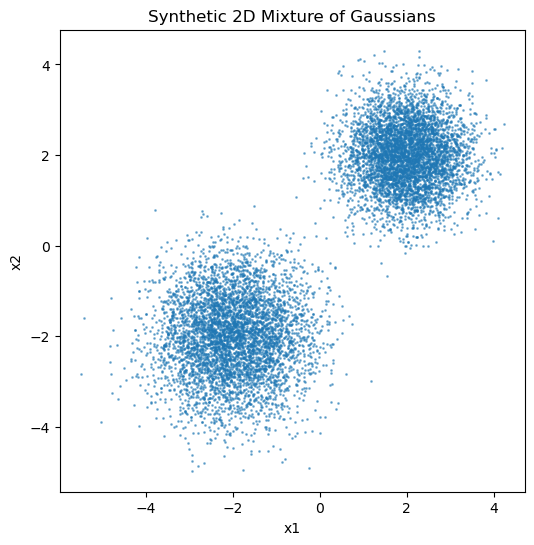

In [3]:
def generate_mixture_data(n_samples=10000):
    # Parameters for two Gaussians
    mean1 = np.array([2, 2])
    cov1 = np.array([[0.5, 0.0], [0.0, 0.5]])
    
    mean2 = np.array([-2, -2])
    cov2 = np.array([[0.8, 0.0], [0.0, 0.8]])
    
    # Sample equally from both Gaussians
    n = n_samples // 2
    samples1 = np.random.multivariate_normal(mean1, cov1, n)
    samples2 = np.random.multivariate_normal(mean2, cov2, n)
    
    samples = np.vstack([samples1, samples2])
    np.random.shuffle(samples)
    return samples

# Generate the data and convert to a PyTorch tensor.
data = generate_mixture_data(10000)
data_tensor = torch.tensor(data, dtype=torch.float32)

# Visualize the data
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
plt.title("Synthetic 2D Mixture of Gaussians")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


In [4]:
def standard_normal_logprob(z):
    # z is of shape (batch_size, dim)
    log_z = -0.5 * z.pow(2) - 0.5 * np.log(2 * np.pi)
    return log_z.sum(dim=1)


Epoch 200/2000, Loss: 3.6046
Epoch 400/2000, Loss: 3.3476
Epoch 600/2000, Loss: 3.3387
Epoch 800/2000, Loss: 3.4685
Epoch 1000/2000, Loss: 3.3983
Epoch 1200/2000, Loss: 3.3883
Epoch 1400/2000, Loss: 3.3203
Epoch 1600/2000, Loss: 3.4898
Epoch 1800/2000, Loss: 3.3736
Epoch 2000/2000, Loss: 3.4767


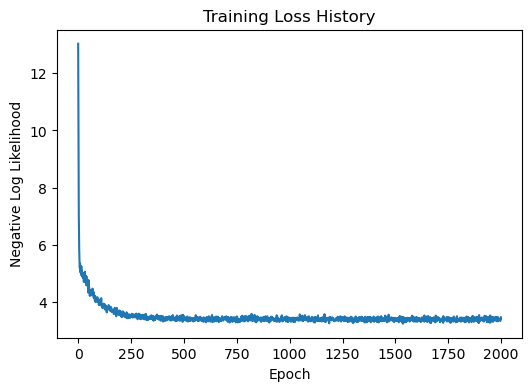

In [5]:
# Hyperparameters
input_size = 2      # 2D data
hidden_size = 50    # More hidden units for better capacity
n_layers = 5        # Number of MADE blocks
batch_size = 256
epochs = 2000
learning_rate = 1e-3

# Instantiate the MAF model and optimizer.
model = MAF(input_size, hidden_size, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
loss_history = []
for epoch in range(epochs):
    # Sample a random batch from data.
    idx = np.random.choice(len(data_tensor), batch_size, replace=False)
    x_batch = data_tensor[idx]
    
    optimizer.zero_grad()
    
    # Forward pass: transform x to z and compute log_det.
    z, log_det = model(x_batch)
    
    # Compute log-probability under base distribution.
    log_prob_z = standard_normal_logprob(z)
    
    # Compute the log-likelihood: log p(x) = log p(z) + log_det
    log_prob = log_prob_z + log_det
    loss = -log_prob.mean()  # negative log likelihood
    
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Plot the training loss history.
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")
plt.show()


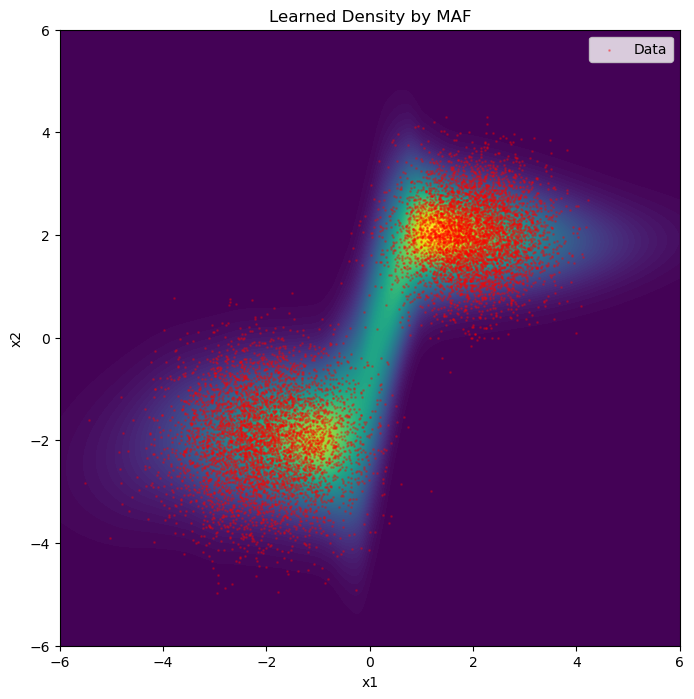

In [6]:
# Create a grid of points for visualization.
grid_x = np.linspace(-6, 6, 300)
grid_y = np.linspace(-6, 6, 300)
xx, yy = np.meshgrid(grid_x, grid_y)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Evaluate the density using the trained MAF.
with torch.no_grad():
    z_grid, log_det_grid = model(grid_tensor)
    log_prob_z = standard_normal_logprob(z_grid)
    log_prob_grid = log_prob_z + log_det_grid
    density = torch.exp(log_prob_grid).cpu().numpy()

density = density.reshape(xx.shape)

# Plot the learned density as a contour plot along with the original data.
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, density, levels=100, cmap="viridis")
plt.scatter(data[:, 0], data[:, 1], c='red', s=1, alpha=0.3, label='Data')
plt.title("Learned Density by MAF")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()
